***Задание 17. Решить краевую задачу для линейного дифференциального уравнения второго порядка. Использовать конечно-разностный метод. Граничные условия аппроксимировать с первым и со вторым порядком точности. Полученные численные решения сравнить с аналитическим решением. Определить погрешность решения.***

In [45]:
import ctypes
import math
import numpy as np
import matplotlib.pyplot as plt

lib = ctypes.CDLL('../1_matrix/a.dll')

lib.create_matrix.restype = ctypes.c_void_p
lib.create_matrix.argtypes = (ctypes.c_int, ctypes.c_int, ctypes.POINTER(ctypes.c_double))
lib.matrix_solve_gauss.argtypes = (
    ctypes.c_void_p, 
    ctypes.POINTER(ctypes.c_double), 
    ctypes.POINTER(ctypes.c_double)
)
lib.free_matrix.argtypes = (ctypes.c_void_p,)

def cpp_matrix_create(rows, cols, data_2d):
    """Создание матрицы в C++ из 2D списка Python"""
    flat = [x for row in data_2d for x in row]
    arr = (ctypes.c_double * len(flat))(*flat)
    return lib.create_matrix(rows, cols, arr)

def cpp_matrix_solve_gauss(A_ptr, b):
    """Решение системы линейных уравнений методом Гаусса"""
    n = len(b)
    b_arr = (ctypes.c_double * n)(*b)
    res_arr = (ctypes.c_double * n)()
    lib.matrix_solve_gauss(A_ptr, b_arr, res_arr)
    result = [res_arr[i] for i in range(n)]
    lib.free_matrix(A_ptr)
    return result

In [46]:
# условие 
a, b = 1.4, 8.0
h_step = 0.6

ya_prime = 3.29  # y'(1.4) = 3.29
yb_prime = 4.77  # y'(8) = 4.77

def p(x):
    """Коэффициент при y' в уравнении y'' + p(x)y' + q(x)y = f(x)"""
    if abs(x) <= 1:
        raise ValueError("Уравнение не определено для |x| <= 1")
    return -x * (x*x - 2) / (x*x * (x*x - 1))

def q(x):
    """Коэффициент при y в уравнении y'' + p(x)y' + q(x)y = f(x)"""
    if abs(x) <= 1:
        raise ValueError("Уравнение не определено для |x| <= 1")
    return (x*x - 2) / (x*x * (x*x - 1))

def f(x):
    """Правая часть уравнения y'' + p(x)y' + q(x)y = f(x)"""
    return 0.0

def analytical_solution(x):
    """Аналитическое решение для варианта 26"""
    if x <= 1:
        raise ValueError("Аналитическое решение не определено для x <= 1")
    return x + x * math.log(x + math.sqrt(x*x - 1))


In [47]:
def solve_boundary_value(a, b, h, order):
    """
    Решает краевую задачу с условиями на производные.
    
    order = 1: аппроксимация производной 1-го порядка (правая/левая разность)
    order = 2: аппроксимация производной 2-го порядка (центральная разность)
    """
    if order not in [1, 2]:
        raise ValueError("Wrong order")
    N = int((b - a) / h) + 1
    x = [a + i * h for i in range(N)]
    
    # Матрица системы A[N][N] и правая часть rhs[N]
    A = [[0.0 for _ in range(N)] for _ in range(N)]
    rhs = [0.0 for _ in range(N)]
    
    # 1. Уравнение на левой границе (i = 0)
    if order == 1:
        # (y1 - y0) / h = ya_prime  →  -y0 + y1 = h * ya_prime
        A[0][0] = -1.0 / h
        A[0][1] = 1.0 / h
        rhs[0] = ya_prime
        # (y[N] - y[N-1]) / h = yb_prime  →  -y[N-2] + y[N-1] = h * yb_prime
        A[N-1][N-2] = -1.0 / h
        A[N-1][N-1] = 1.0 / h
        rhs[N-1] = yb_prime

    else:  # order == 2
        # (-3*y0 + 4*y1 - y2) / (2*h) = ya_prime
        A[0][0] = -3.0 / (2.0 * h)
        A[0][1] = 4.0 / (2.0 * h)
        A[0][2] = -1.0 / (2.0 * h)
        rhs[0] = ya_prime
        # (y[N-2] - 4*y[N-1] + 3*y[N]) / (2*h) = yb_prime
        A[N-1][N-3] = 1.0 / (2.0 * h)
        A[N-1][N-2] = -4.0 / (2.0 * h)
        A[N-1][N-1] = 3.0 / (2.0 * h)
        rhs[N-1] = yb_prime
    
    # 2. Уравнения во внутренних точках (i = 1, ..., N-2)
    for i in range(1, N-1):
        xi = x[i]
        # (1 - p(x[i])*h/2)y[i-1] + (-2+h^2*q(x[i]))*y[i] + (1 + p(x[i])*h/2)y[i+1]=h^2*f(x[i])
        # (y[i+1] - 2*y[i] + y[i-1])/h^2 + p(xi)*(y[i+1] - y[i-1])/(2*h) + q(xi)*y[i] = f(xi)
        A[i][i-1] = 1.0/(h*h) - p(xi)/(2.0*h)
        A[i][i]   = -2.0/(h*h) + q(xi)
        A[i][i+1] = 1.0/(h*h) + p(xi)/(2.0*h)
        rhs[i] = f(xi)
    

    A_ptr = cpp_matrix_create(N, N, A)
    y = cpp_matrix_solve_gauss(A_ptr, rhs)
    
    return x, y

Результаты решения краевой задачи для варианта 26:
    x      | Аналитическое | 1-й порядок  | Погрешность  | 2-й порядок  | Погрешность 
  1.4000   |   2.613821    |   2.375046   | 2.387746e-01 |   2.757038   | 1.432176e-01
  2.0000   |   4.633916    |   4.349046   | 2.848698e-01 |   4.797868   | 1.639524e-01
  2.6000   |   6.784539    |   6.471776   | 3.127623e-01 |   6.972358   | 1.878194e-01
  3.2000   |   9.059002    |   8.727155   | 3.318468e-01 |   9.266055   | 2.070537e-01
  3.8000   |  11.439396    |  11.095484   | 3.439121e-01 |  11.661259   | 2.218621e-01
  4.4000   |  13.910956    |  13.561002   | 3.499540e-01 |  14.143802   | 2.328462e-01
  5.0000   |  16.462158    |  16.111458   | 3.507004e-01 |  16.702678   | 2.405192e-01
  5.6000   |  19.083931    |  18.737207   | 3.467233e-01 |  19.329217   | 2.452865e-01
  6.2000   |  21.768996    |  21.430510   | 3.384865e-01 |  22.016465   | 2.474685e-01
  6.8000   |  24.511408    |  24.185035   | 3.263734e-01 |  24.758732   | 2.473

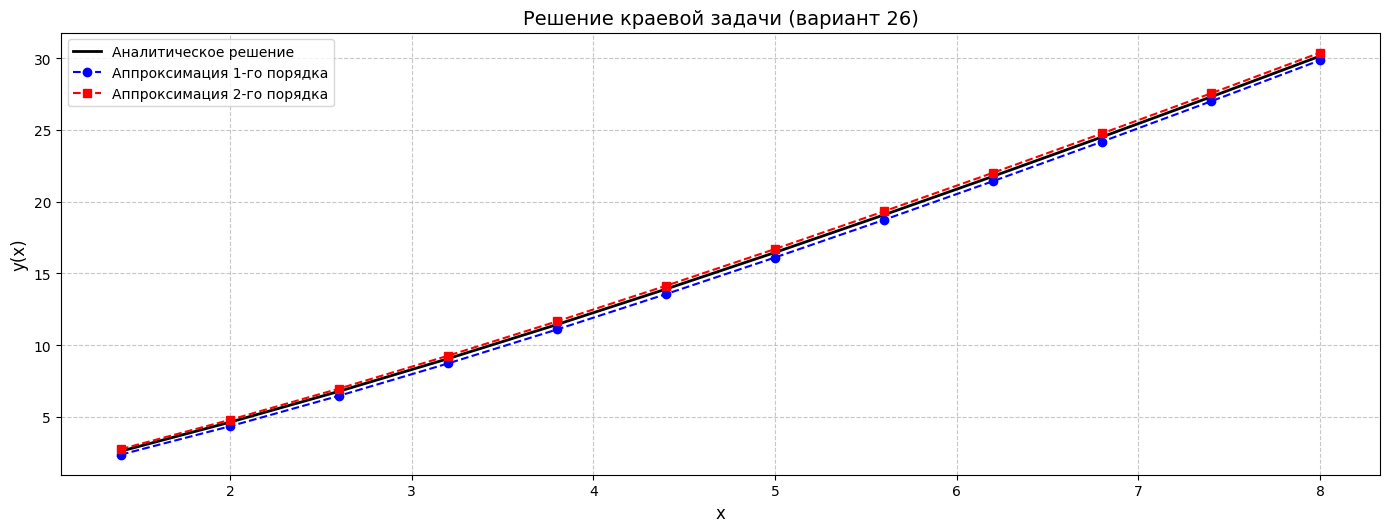

In [ ]:

x1, y1 = solve_boundary_value(a, b, h_step, 1)

x2, y2 = solve_boundary_value(a, b,h_step, 2)

y_analytical = [analytical_solution(xi) for xi in x1]

error_1st = [abs(y1[i] - y_analytical[i]) for i in range(len(x1))]
error_2nd = [abs(y2[i] - y_analytical[i]) for i in range(len(x2))]

max_error_1st = max(error_1st)
max_error_2nd = max(error_2nd)

print("Результаты решения краевой задачи для варианта 26:")
print("=" * 90)
print(f"{'x':^10} | {'Аналитическое':^12} | {'1-й порядок':^12} | {'Погрешность':^12} | {'2-й порядок':^12} | {'Погрешность':^12}")
print("=" * 90)

for i in range(len(x1)):
    print(f"{x1[i]:^10.4f} | {y_analytical[i]:^12.6f}  | {y1[i]:^12.6f} | {error_1st[i]:^12.6e} | {y2[i]:^12.6f} | {error_2nd[i]:^12.6e}")

print("=" * 90)
print(f"Максимальная погрешность (1-й порядок): {max_error_1st:.6e}")
print(f"Максимальная погрешность (2-й порядок): {max_error_2nd:.6e}")

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(x1, y_analytical, 'k-', linewidth=2, label='Аналитическое решение')
plt.plot(x1, y1, 'bo--', markersize=6, linewidth=1.5, label='Аппроксимация 1-го порядка')
plt.plot(x2, y2, 'rs--', markersize=6, linewidth=1.5, label='Аппроксимация 2-го порядка')

plt.xlabel('x', fontsize=12)
plt.ylabel('y(x)', fontsize=12)
plt.title('Решение краевой задачи (вариант 26)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
